In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'PAAS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,163,-185,-21,-526,146,64,253,731,3,...,53,18,39,174,0,455,1,-30,152.0,2015-02-24
1,2015-03-31,178,-176,3,-20,110,102,240,687,3,...,48,23,39,172,0,457,12,-32,152.0,2015-05-10
2,2015-06-30,174,-175,-1,-7,183,107,237,668,3,...,58,24,37,175,0,449,21,-30,152.0,2015-08-09
3,2015-09-30,159,-185,-26,-68,155,102,216,619,3,...,59,20,38,175,0,440,33,-31,152.0,2015-11-09
4,2015-12-31,163,-171,-8,-137,134,60,204,552,3,...,54,20,2,131,36,418,23,-54,152.0,2016-02-24


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-11-09,365.00,616,-554,62,-23,348,150,701,...,0,7534,191,0,54,516,705,2686,115,-109
36,2023-12-31,2024-02-24,365.00,670,-605,65,-68,400,138,712,...,0,7213,498,0,32,624,697,2441,167,-169
37,2024-03-31,2024-05-06,364.49,601,-530,71,31,301,149,744,...,0,7080,470,0,49,626,698,2399,61,-87
38,2024-06-30,2024-08-05,362.95,686,-552,134,-21,337,149,743,...,0,7043,467,0,73,653,700,2420,162,-76
39,2024-09-30,2024-11-04,363.07,716,-540,176,57,439,150,810,...,0,7152,489,0,53,733,701,2507,226,-75


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,365.00,616,-554,62,-23,348,150,701,...,7534,191,0,54,516,705,2686,115,-109,1.341033
36,2023-12-31,2024-02-24,365.00,670,-605,65,-68,400,138,712,...,7213,498,0,32,624,697,2441,167,-169,1.361617
37,2024-03-31,2024-05-06,364.49,601,-530,71,31,301,149,744,...,7080,470,0,49,626,698,2399,61,-87,1.347550
38,2024-06-30,2024-08-05,362.95,686,-552,134,-21,337,149,743,...,7043,467,0,73,653,700,2420,162,-76,1.367756
39,2024-09-30,2024-11-04,363.07,716,-540,176,57,439,150,810,...,7152,489,0,53,733,701,2507,226,-75,1.364419


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,365.00,826.076281,-742.932239,83.144041,-30.843757,466.679457,201.154938,940.064079,...,10103.342043,256.137288,0.0,72.415778,691.972988,945.428211,3602.014432,154.218786,-146.172589,1.341033
36,2023-12-31,2024-02-24,365.00,912.283651,-823.778520,88.505130,-92.589982,544.646956,187.903200,969.471581,...,9821.346228,678.085460,0.0,43.571756,849.649251,949.047320,3323.708047,227.390104,-230.113339,1.361617
37,2024-03-31,2024-05-06,364.49,809.877738,-714.201666,95.676072,41.774060,405.612644,200.784997,1002.577433,...,9540.656218,633.348647,0.0,66.029965,843.566496,940.590119,3232.773202,82.200569,-117.236877,1.347550
38,2024-06-30,2024-08-05,362.95,938.280719,-755.001395,183.279324,-28.722879,460.933823,203.795666,1016.242820,...,9633.106567,638.742122,0.0,99.846199,893.144766,957.429305,3309.969884,221.576496,-103.949467,1.367756
39,2024-09-30,2024-11-04,363.07,976.923823,-736.786123,240.137699,77.771869,598.979830,204.662812,1105.179185,...,9758.322878,667.200767,0.0,72.314194,1000.118941,956.457542,3420.597798,308.358637,-102.331406,1.364419


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-03-02,10.044385,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.774529,0.225471,0.0,0.0,0.0,0.0,-0.128834,-3.226994,0.0,0.0
1,2015-03-09,10.114503,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.774529,0.225471,0.0,0.0,0.0,0.0,-0.128834,-3.226994,0.0,0.0
2,2015-03-16,10.456326,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.774529,0.225471,0.0,0.0,0.0,0.0,-0.128834,-3.226994,0.0,0.0
3,2015-03-23,10.088211,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.774529,0.225471,0.0,0.0,0.0,0.0,-0.128834,-3.226994,0.0,0.0
4,2015-03-30,9.877855,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.774529,0.225471,0.0,0.0,0.0,0.0,-0.128834,-3.226994,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-03-02,10.044385,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.0,-0.128834,-3.226994,0.0,0.0,inf,0.859959,inf,inf,inf
1,2015-03-09,10.114503,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.0,-0.128834,-3.226994,0.0,0.0,inf,0.865962,inf,inf,inf
2,2015-03-16,10.456326,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.0,-0.128834,-3.226994,0.0,0.0,inf,0.895228,inf,inf,inf
3,2015-03-23,10.088211,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.0,-0.128834,-3.226994,0.0,0.0,inf,0.863711,inf,inf,inf
4,2015-03-30,9.877855,2014-12-31,185.147447,0.0,11.680072,152.0,0.0,0.0,165.837591,...,0.0,-0.128834,-3.226994,0.0,0.0,inf,0.845702,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

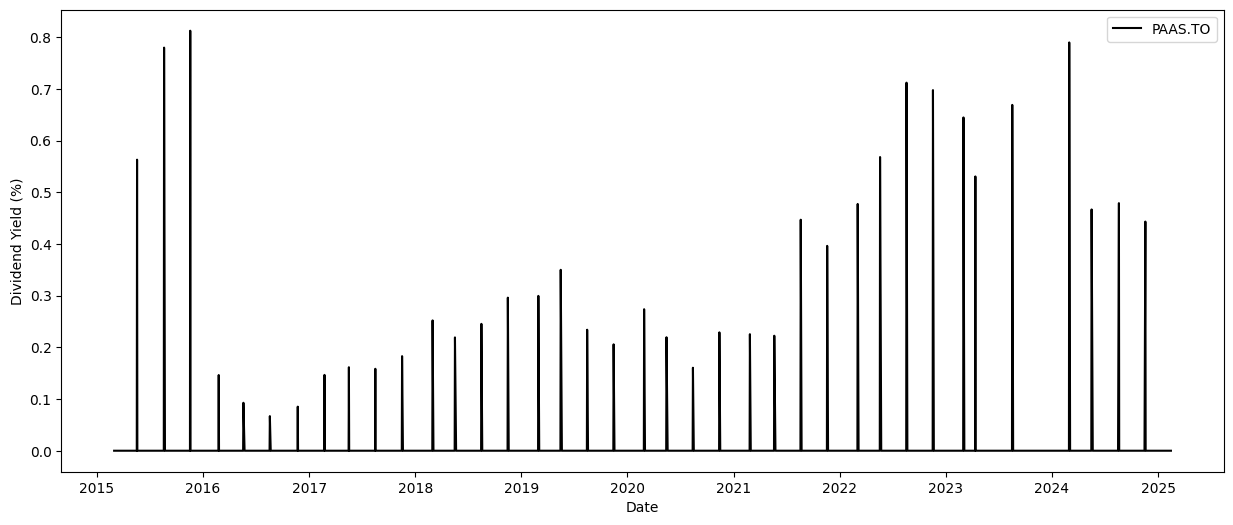

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.048109
share_price      1.000000
Name: share_price, dtype: float64


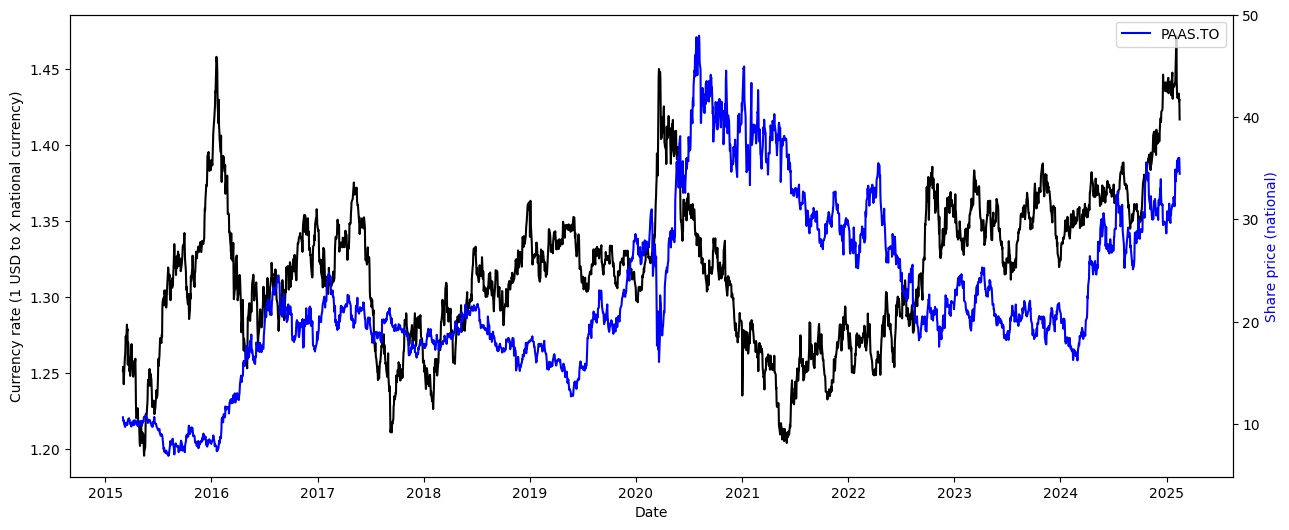

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

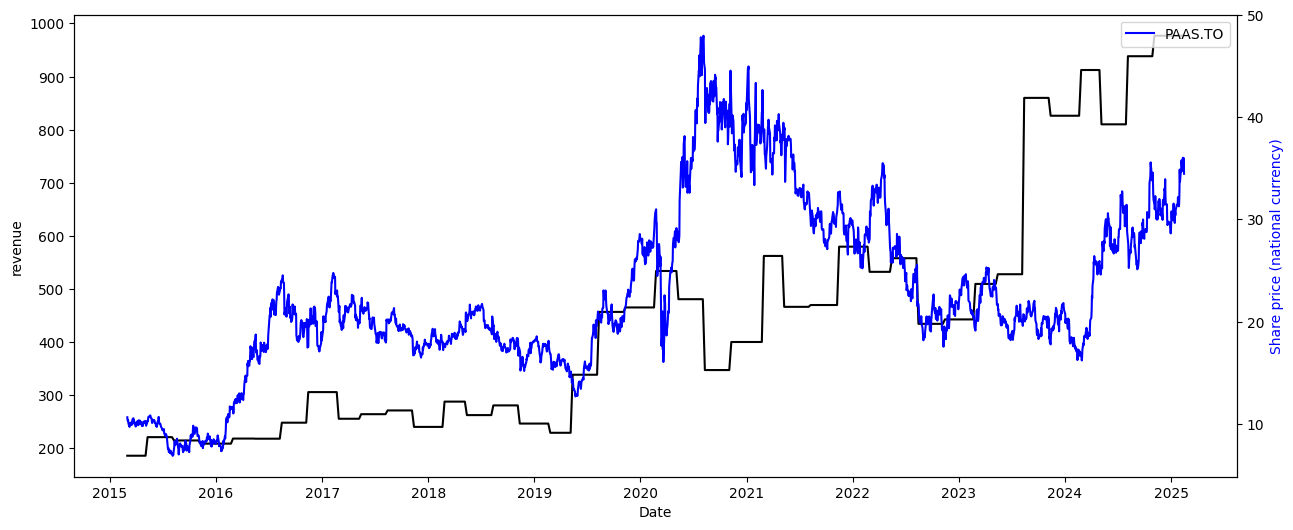

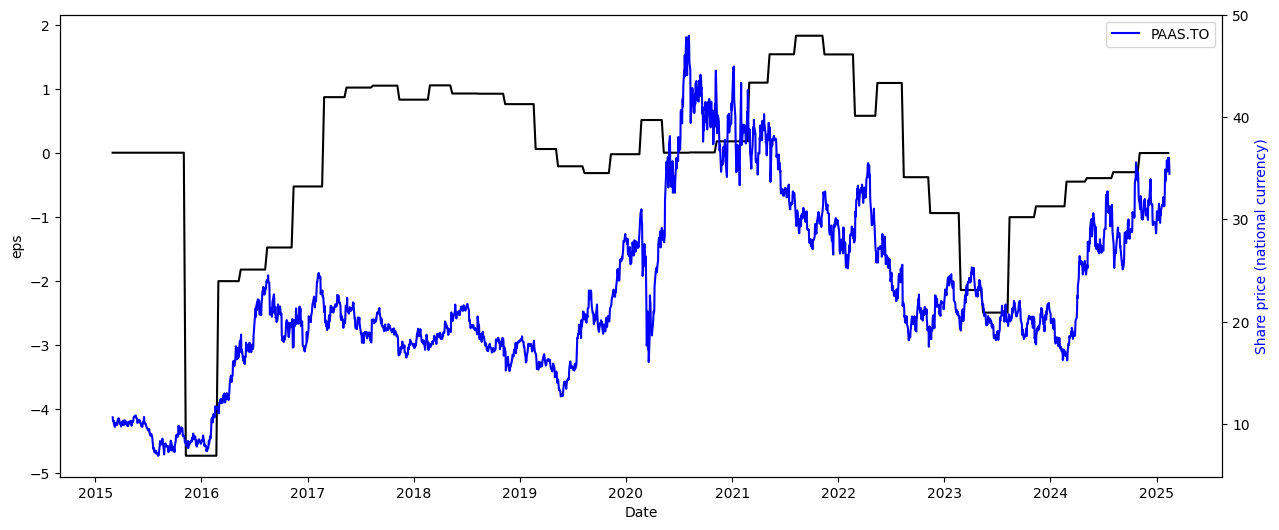

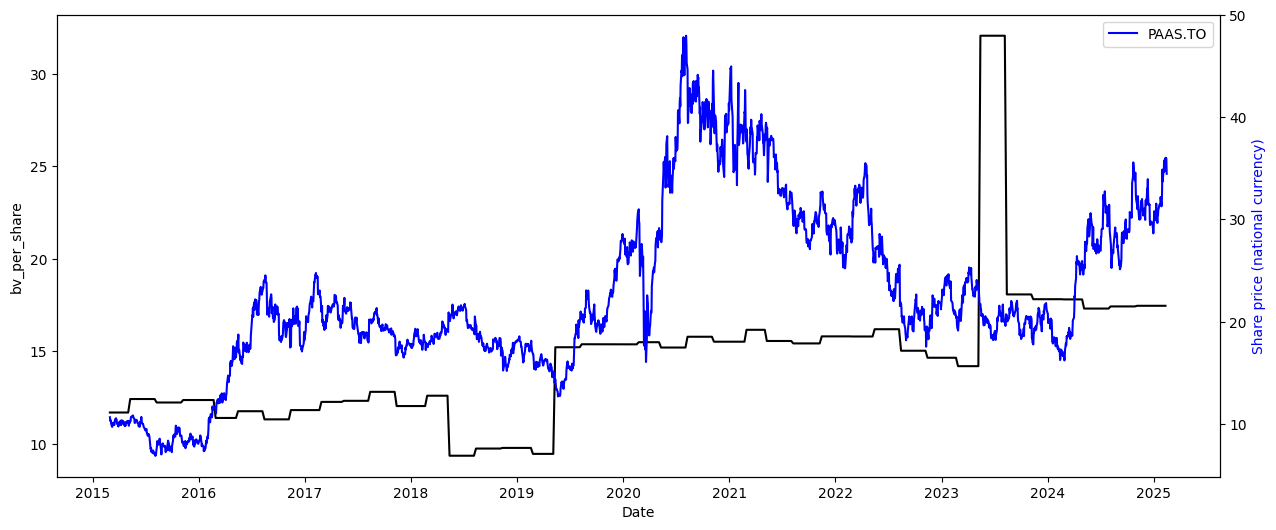

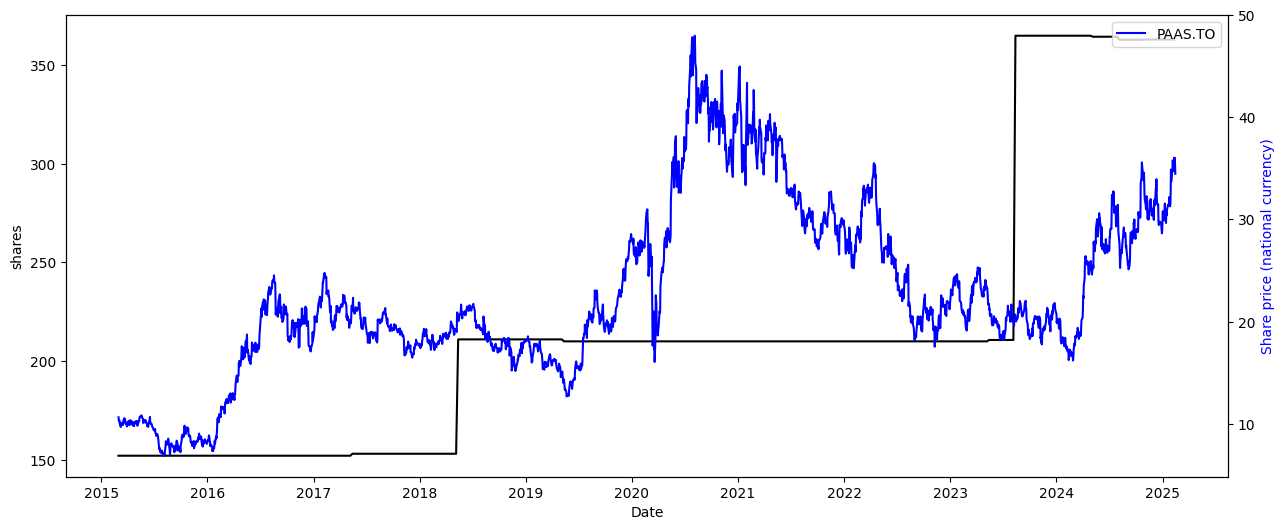

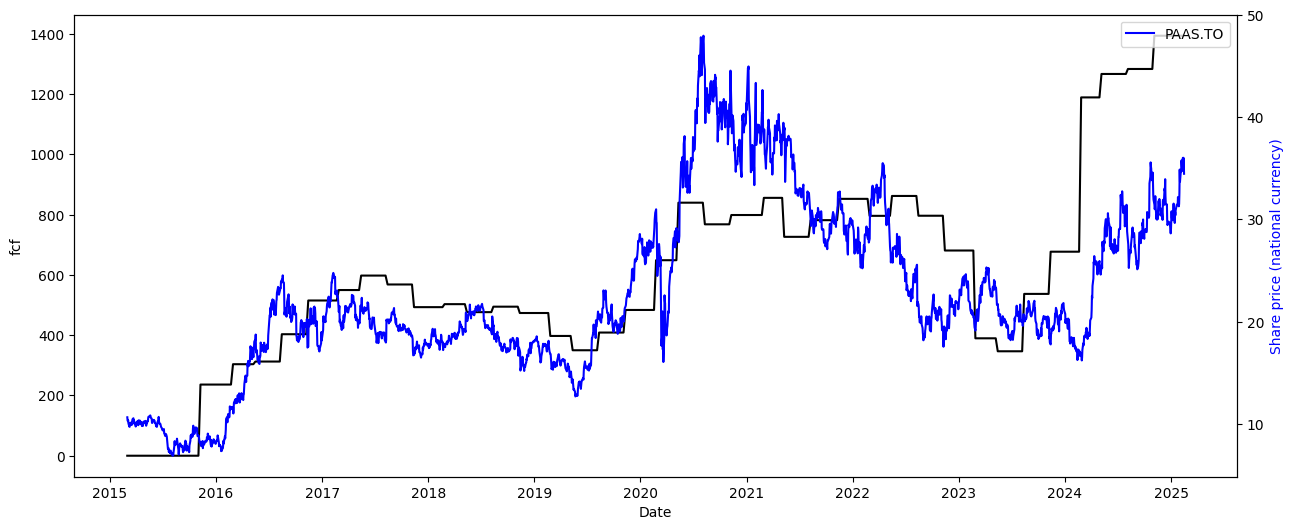

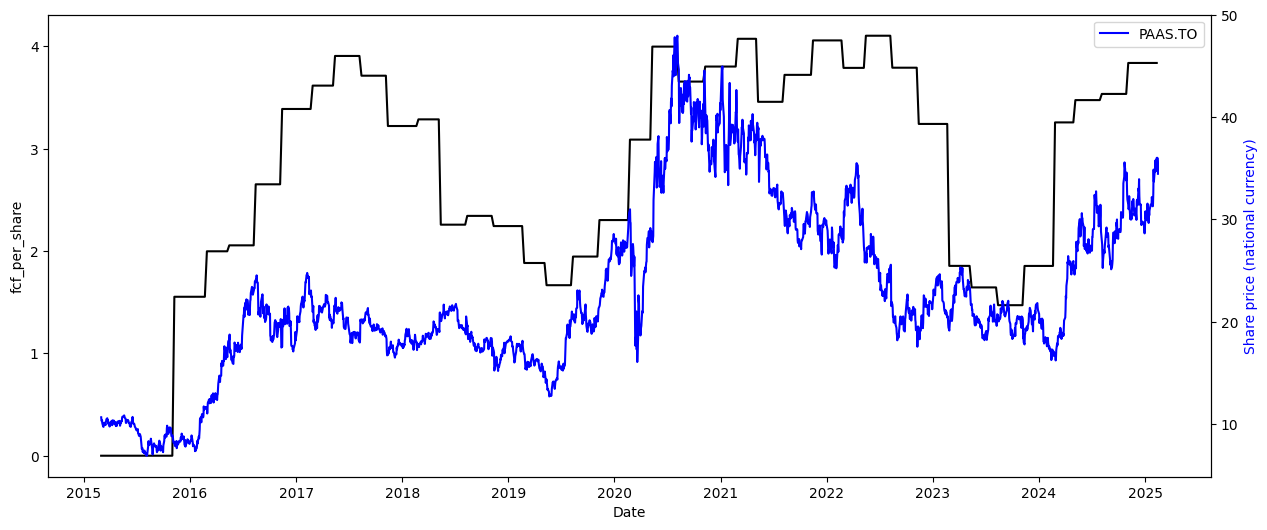

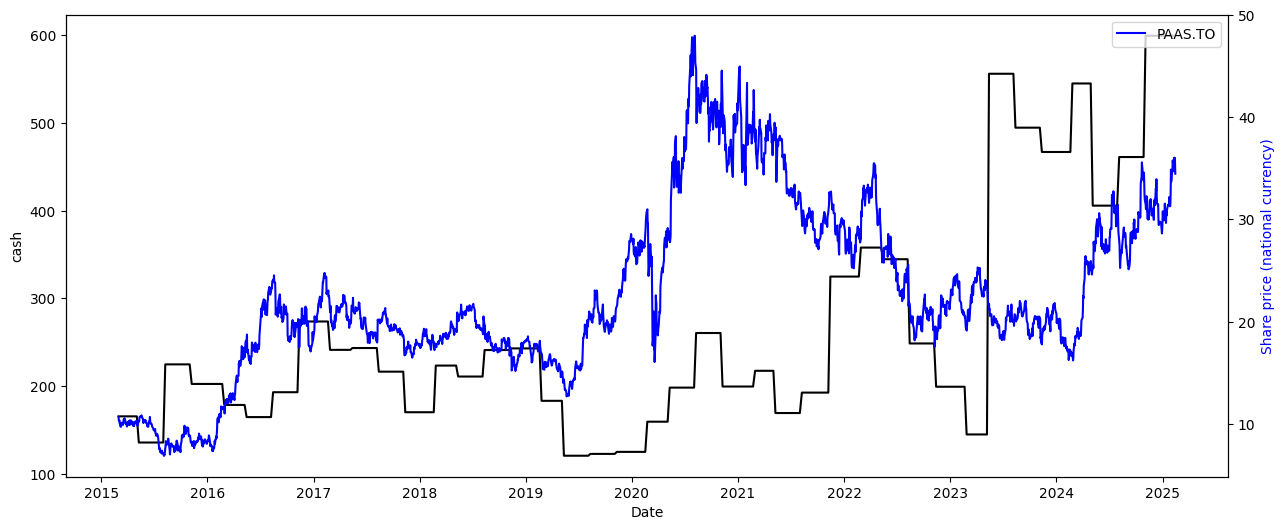

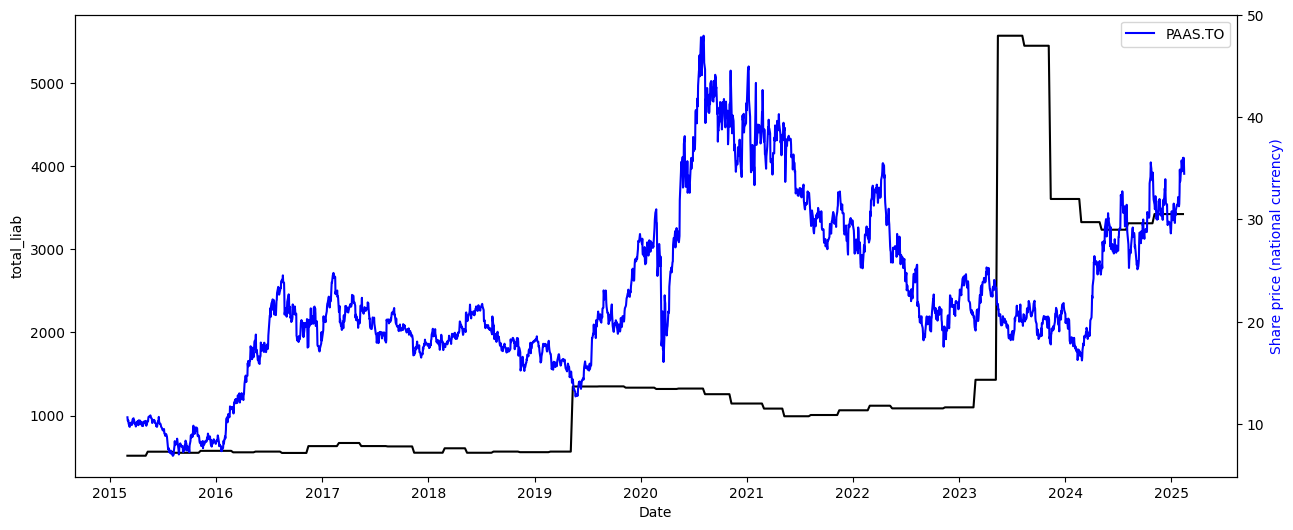

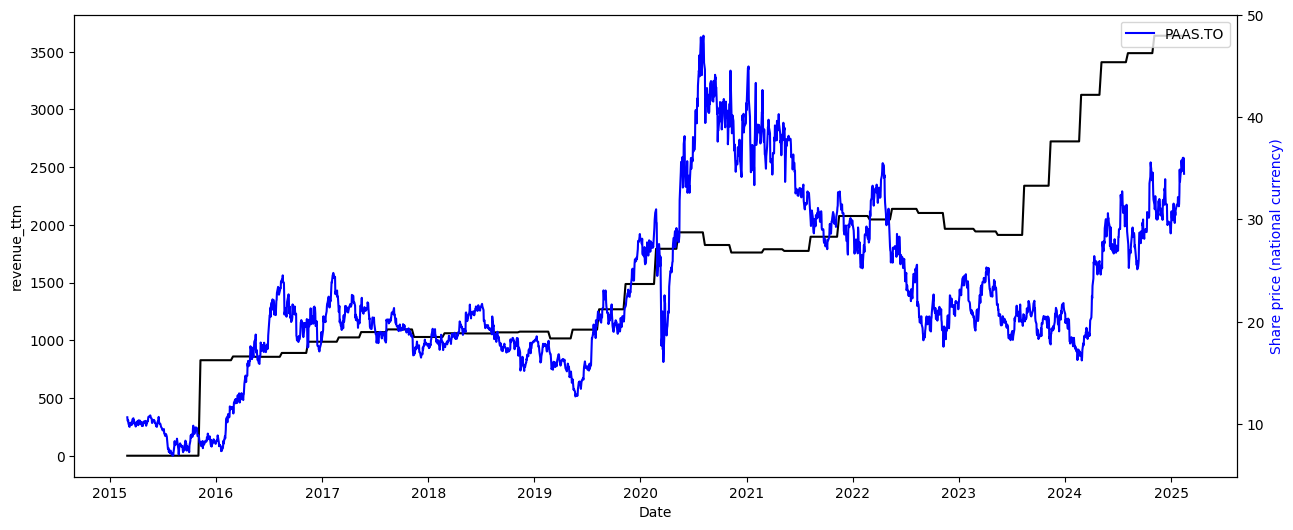

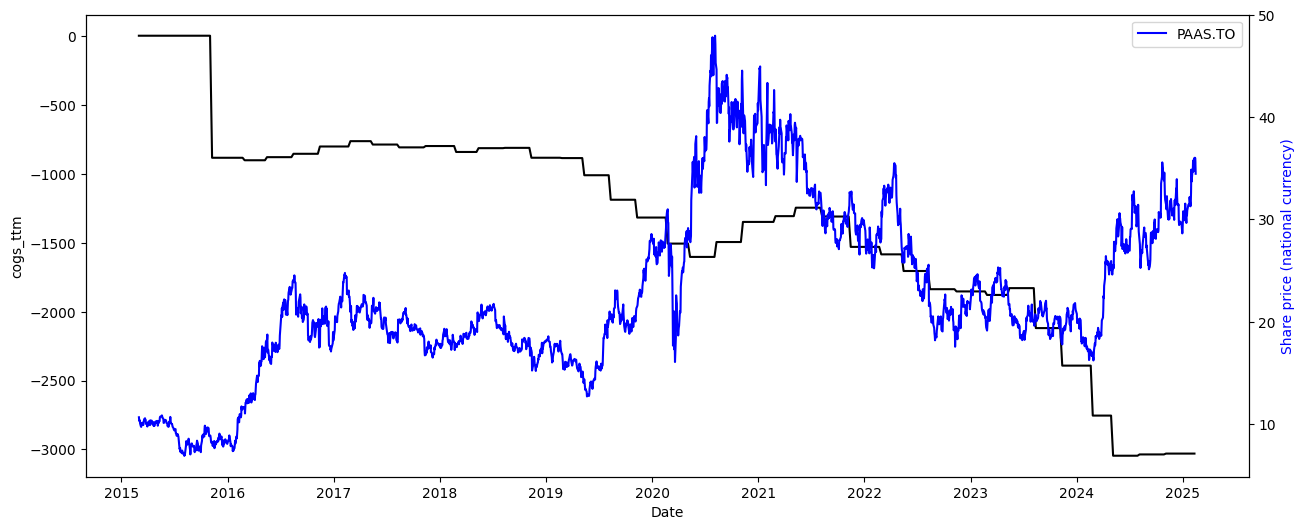

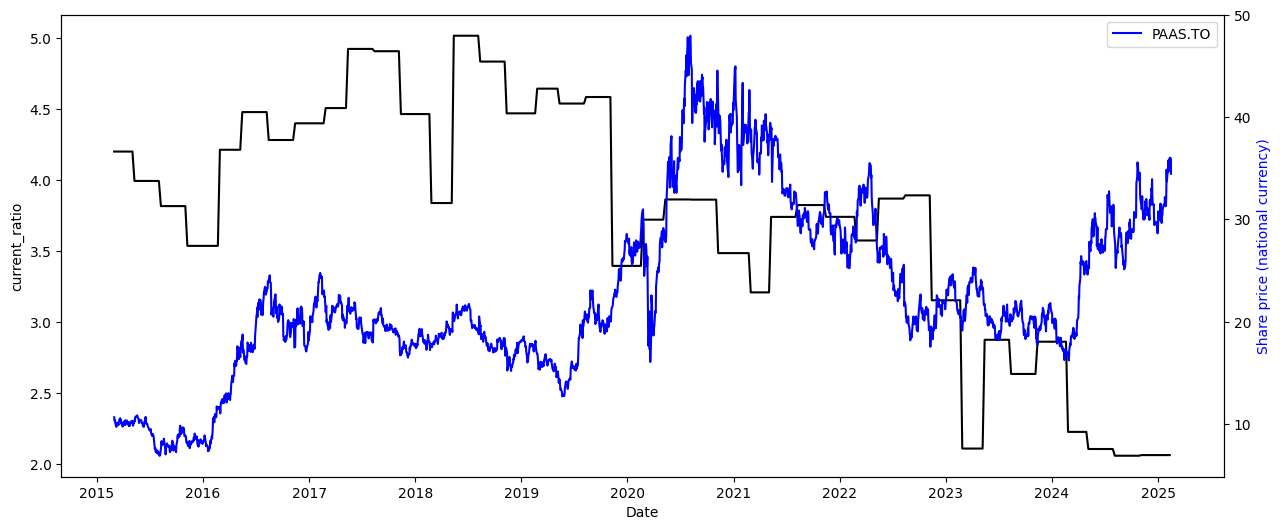

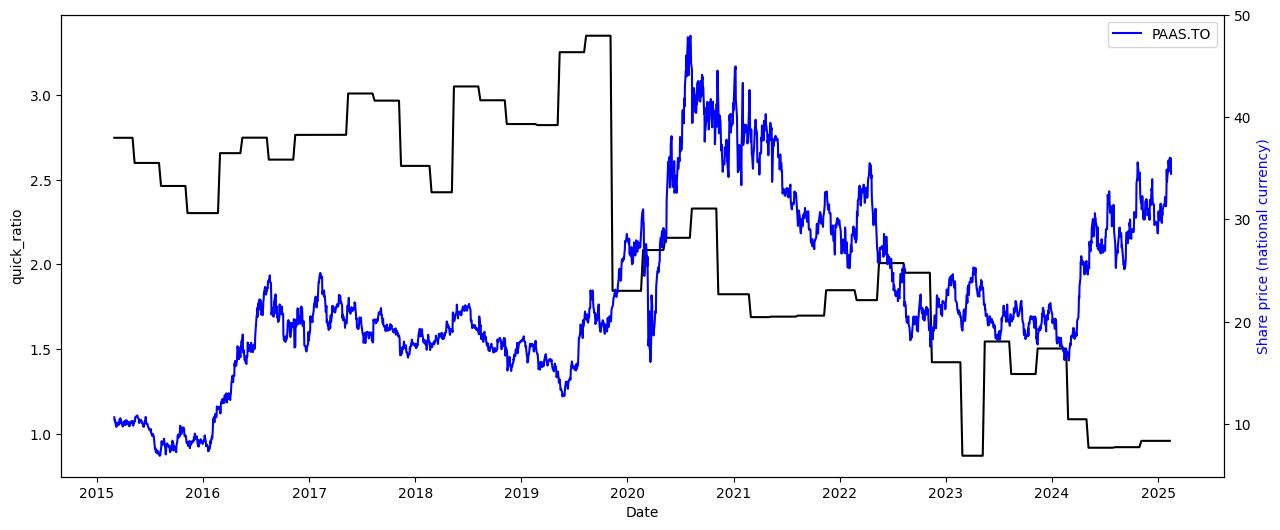

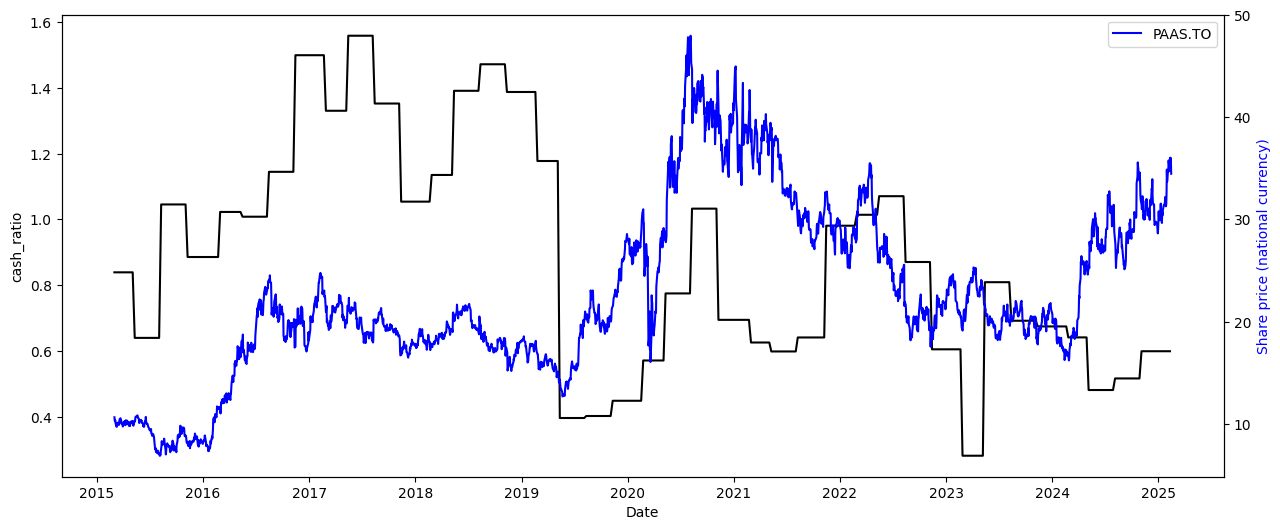

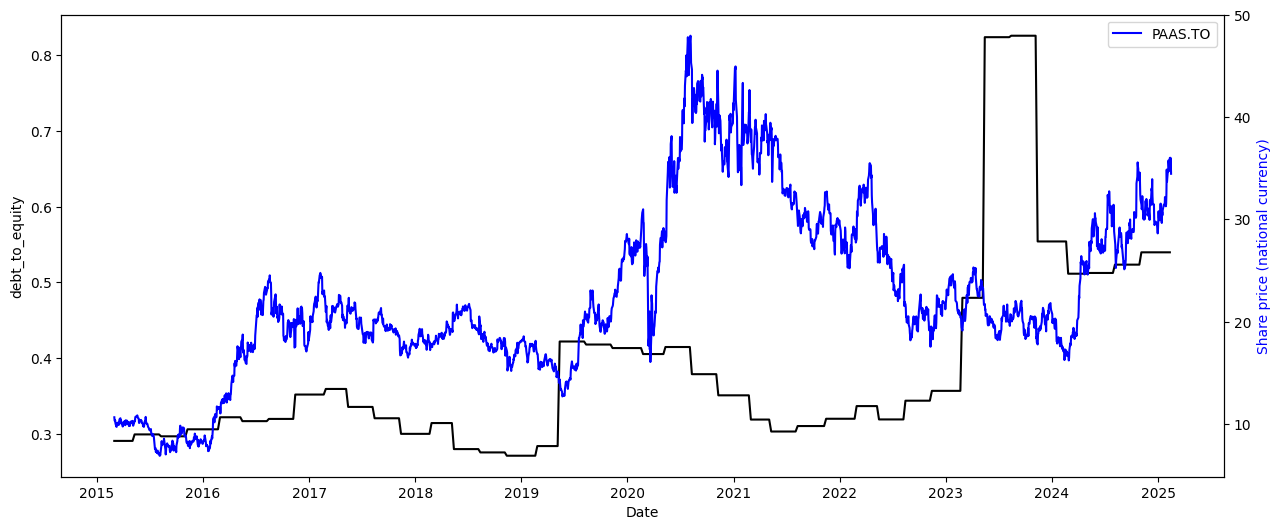

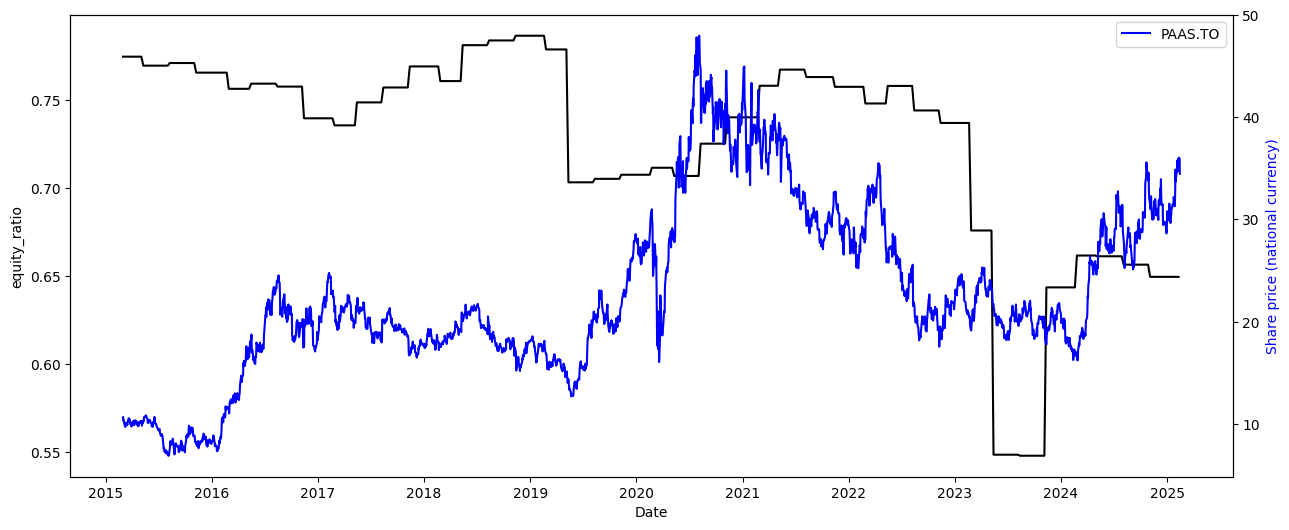

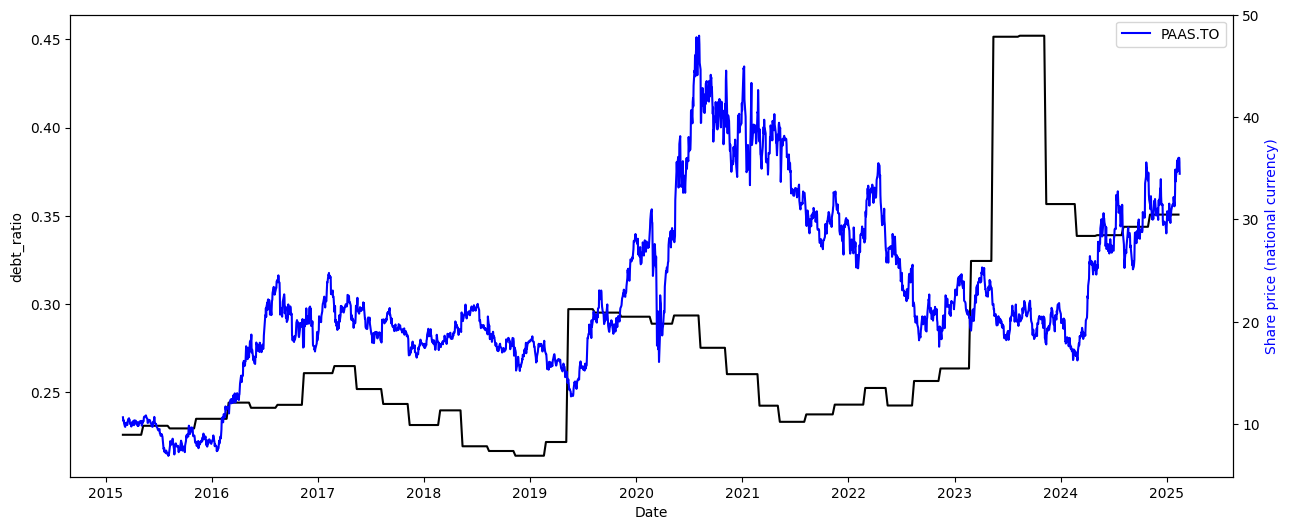

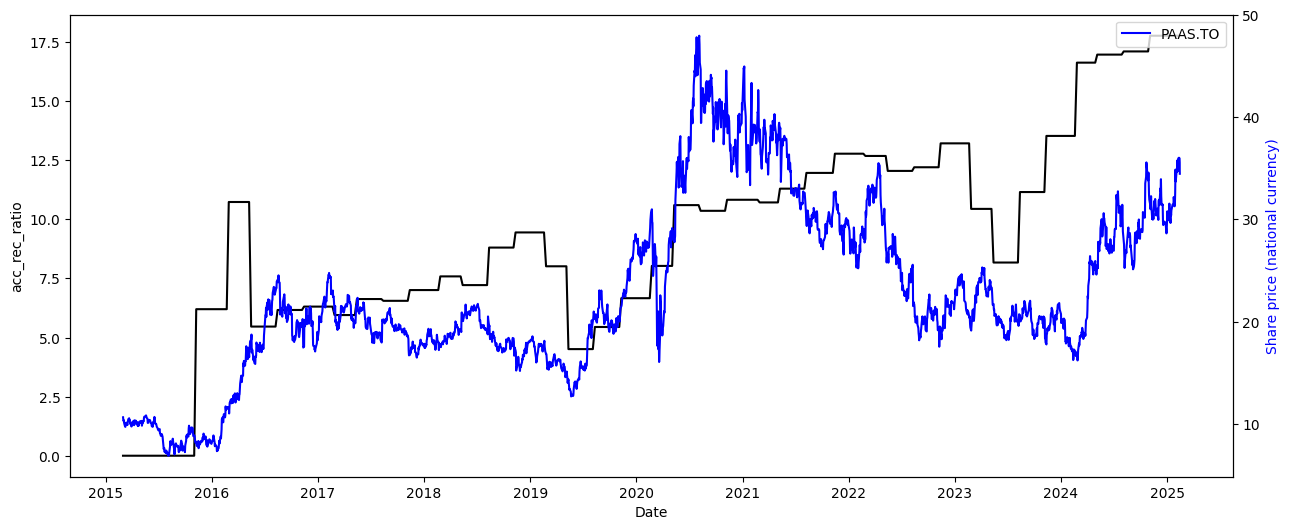

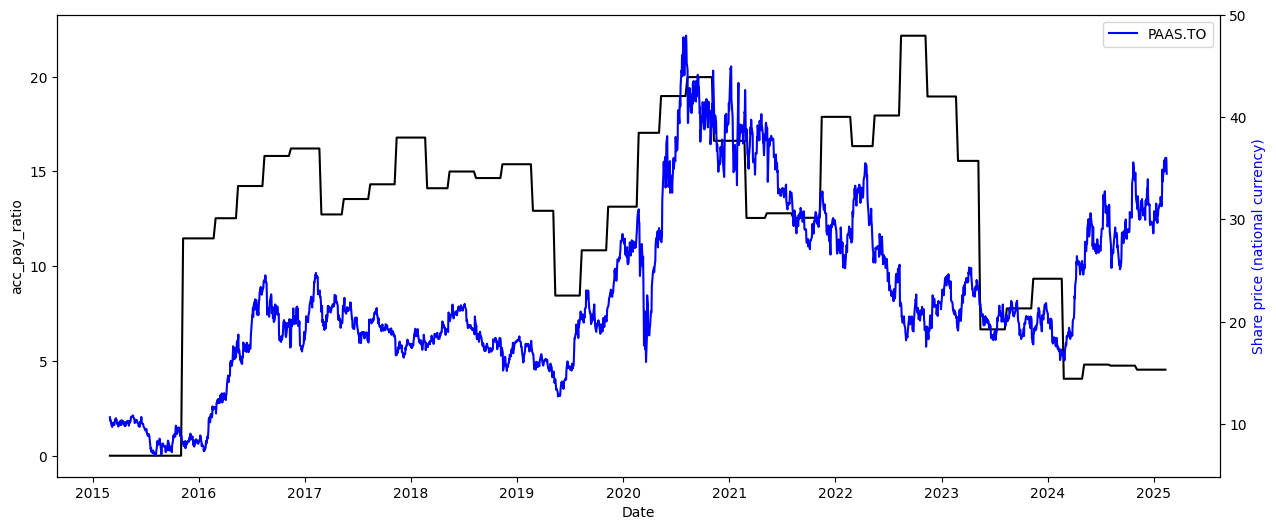

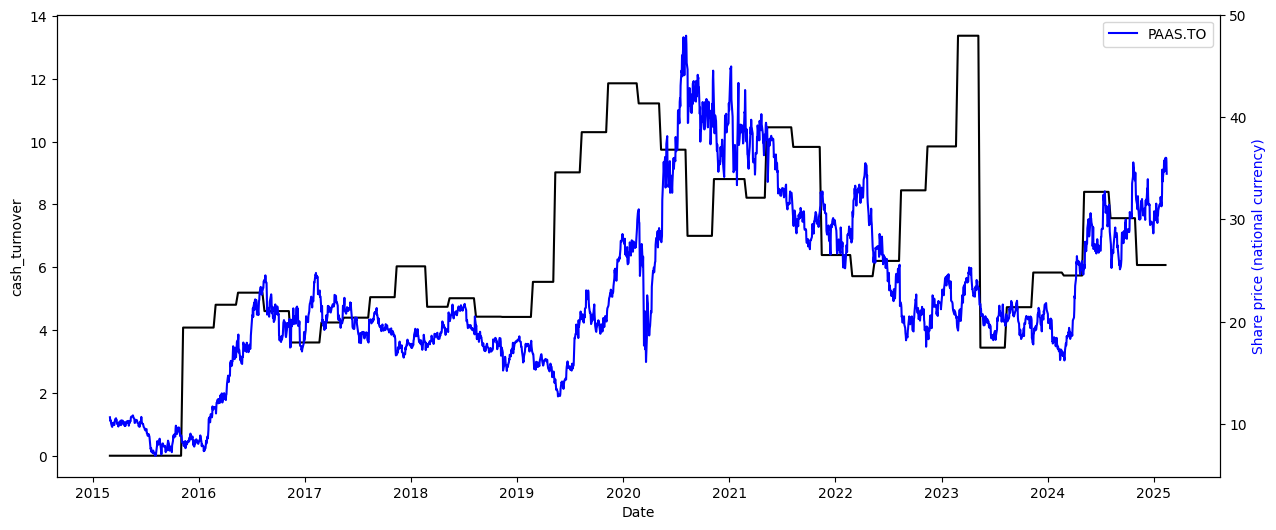

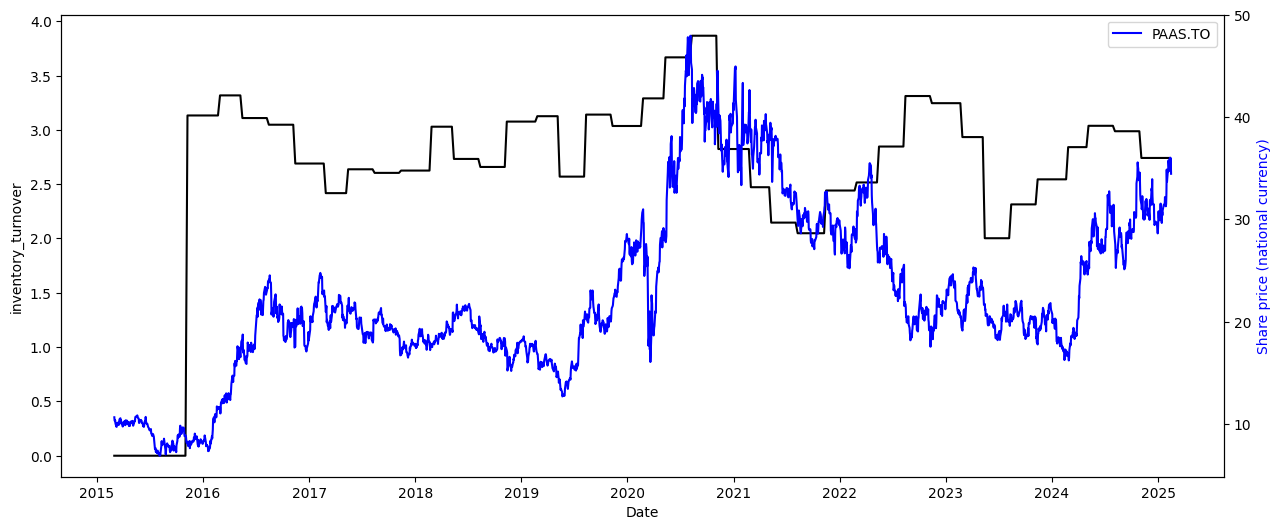

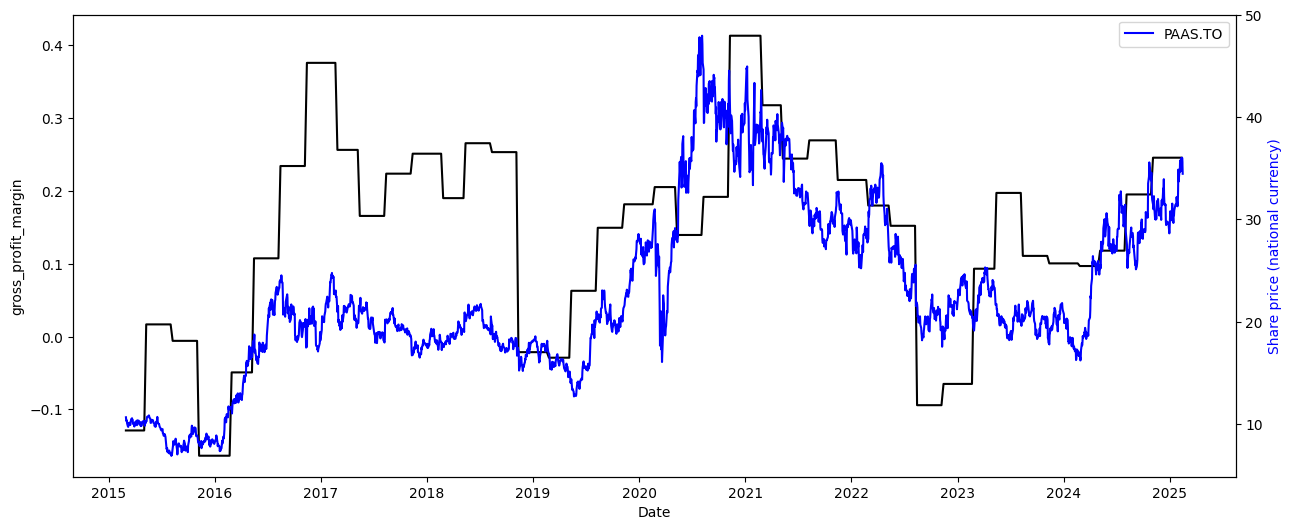

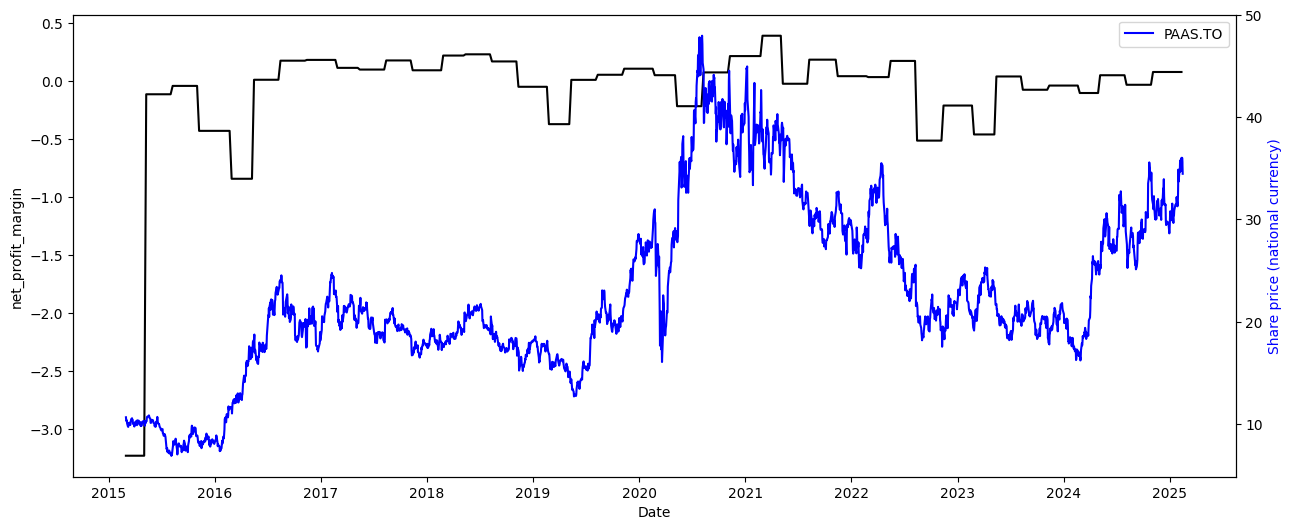

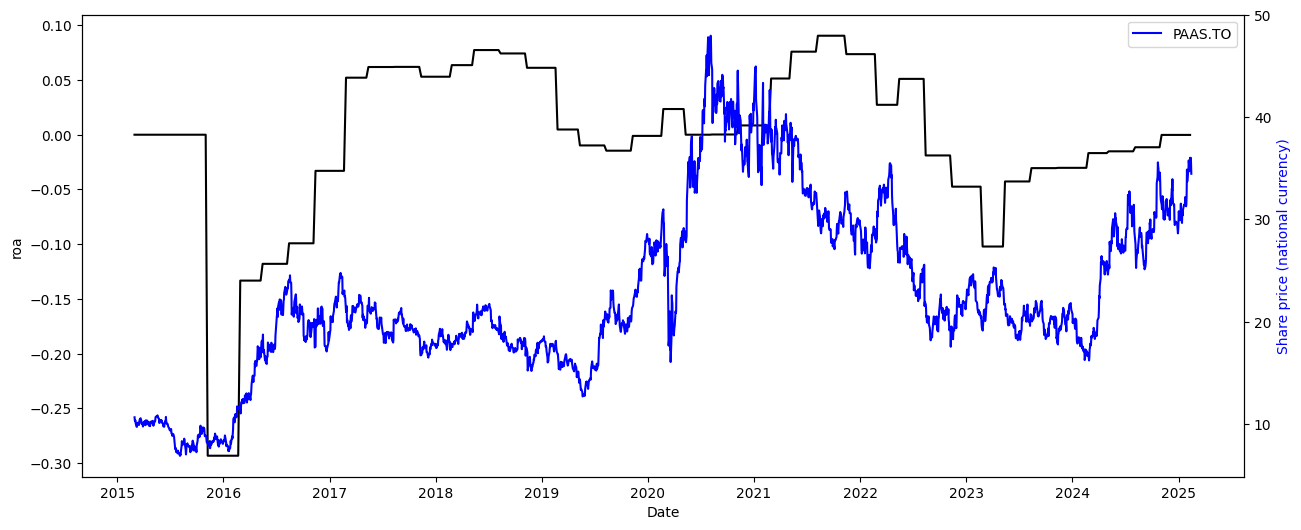

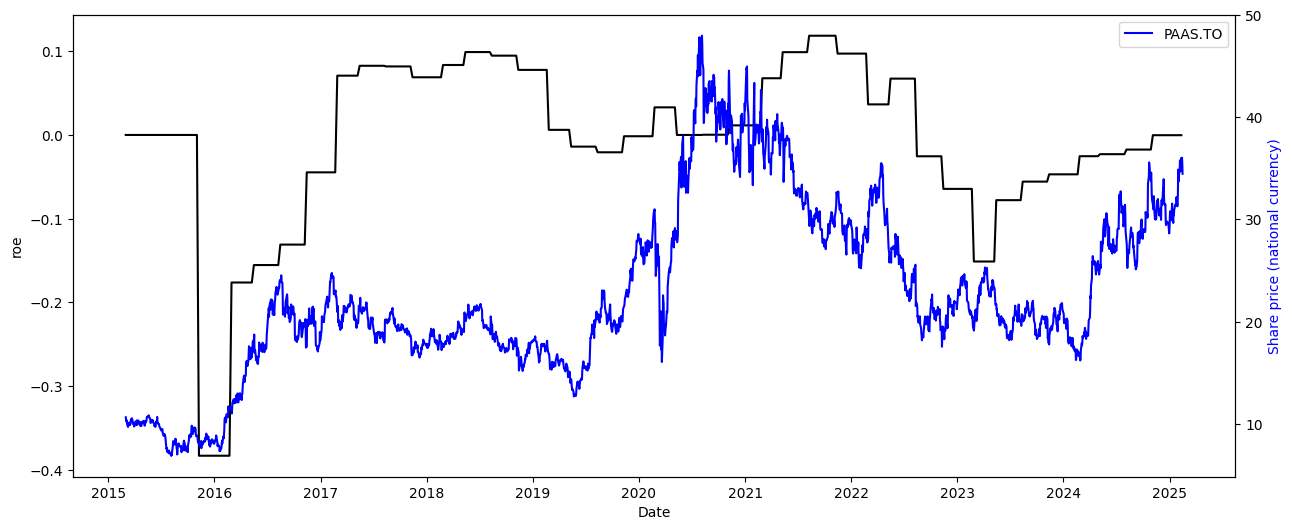

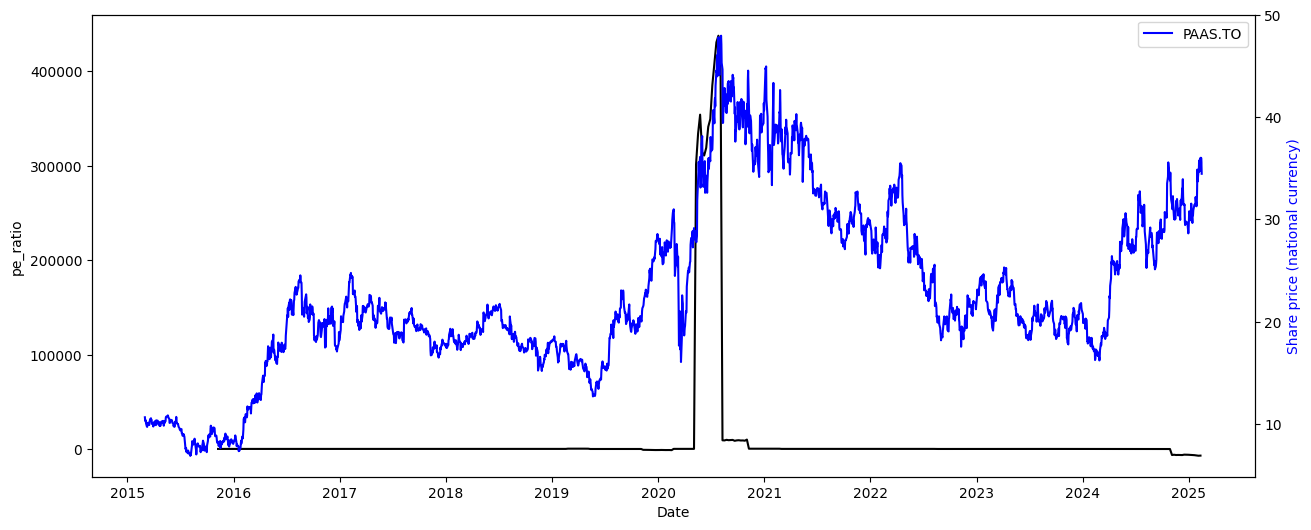

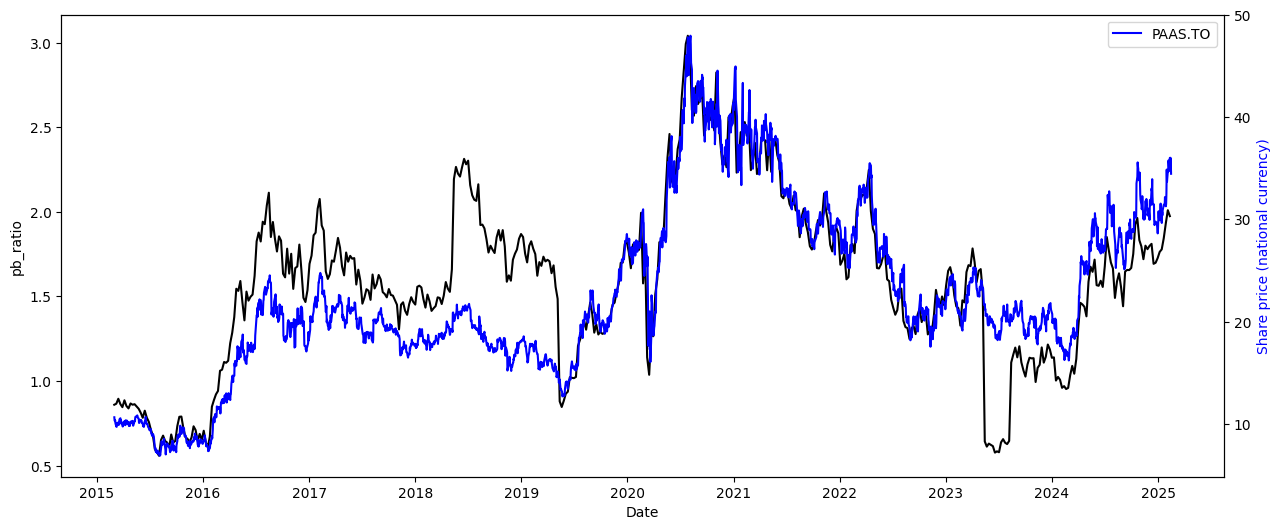

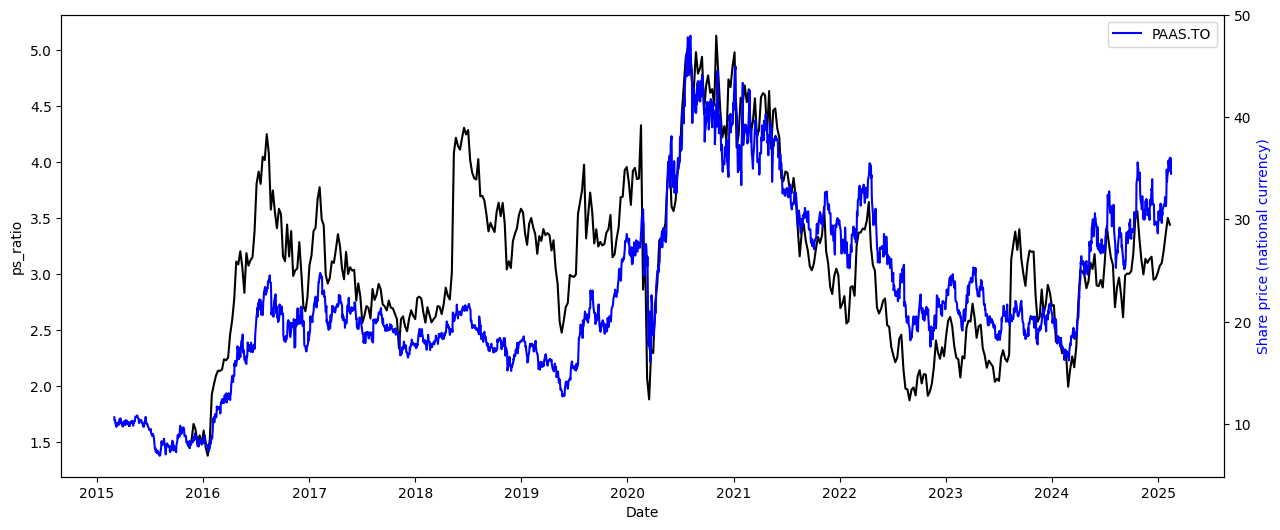

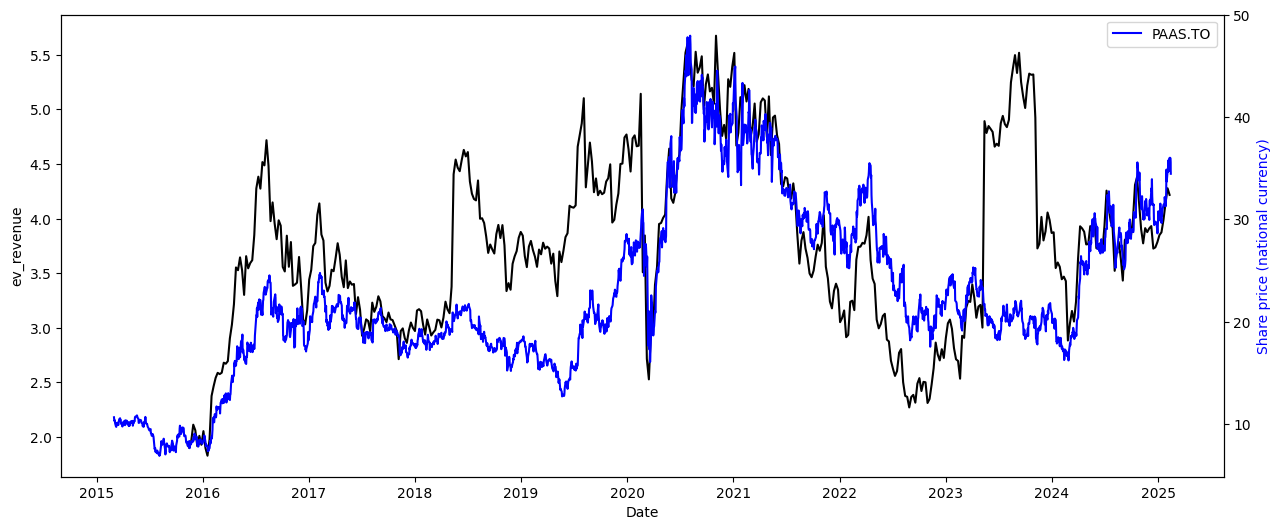

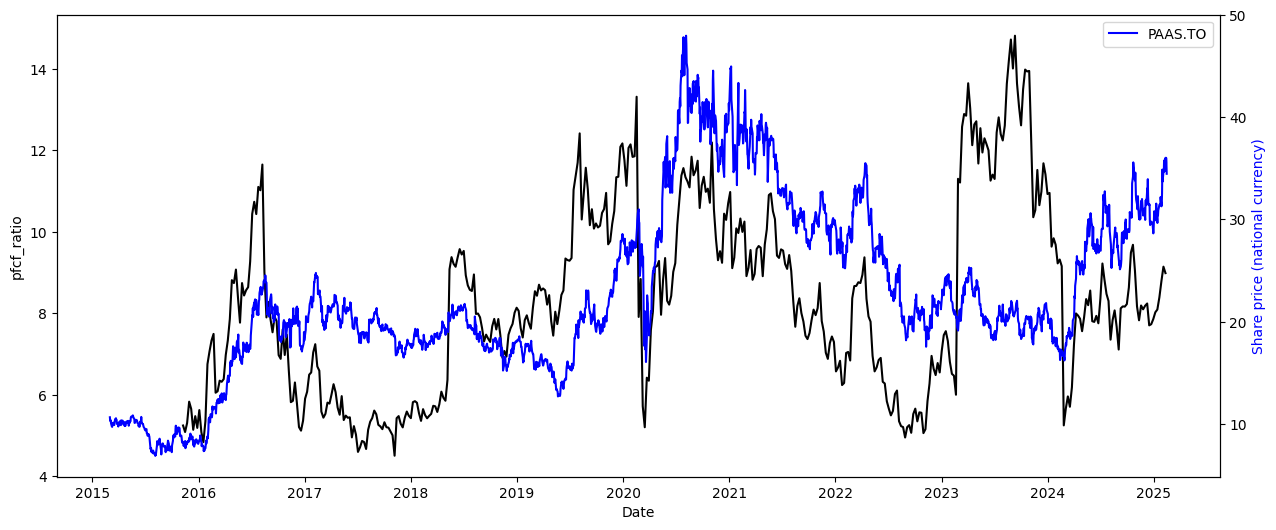

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

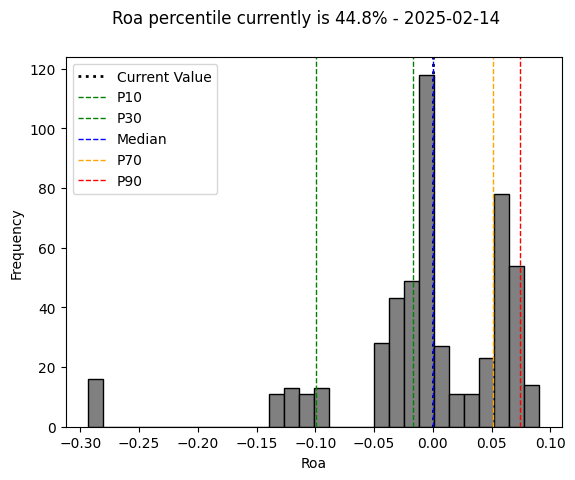

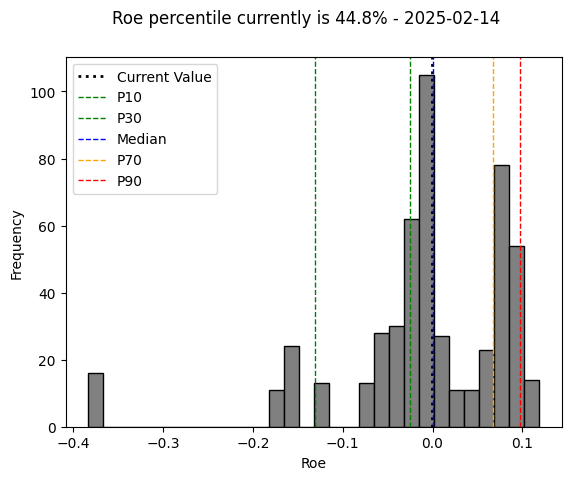

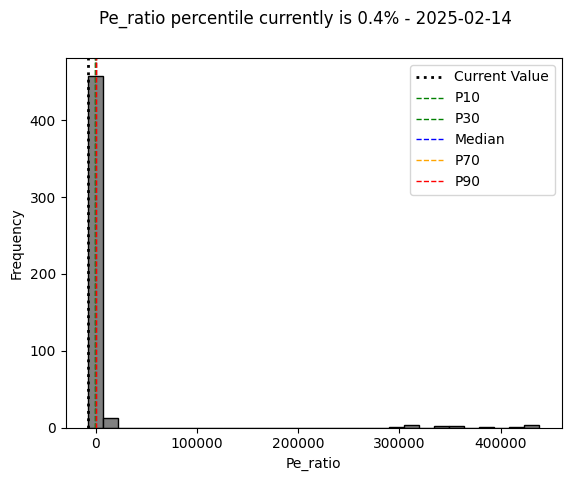

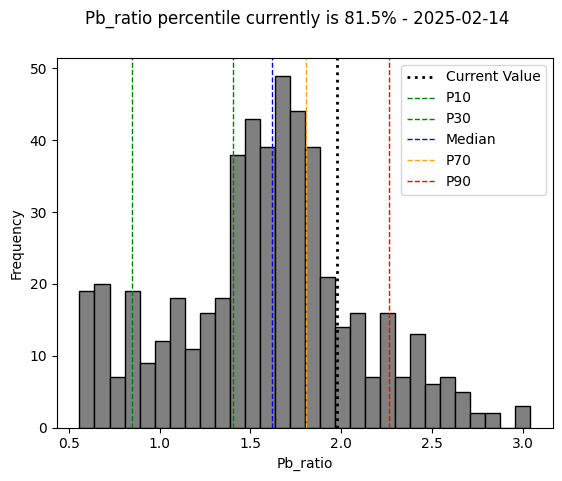

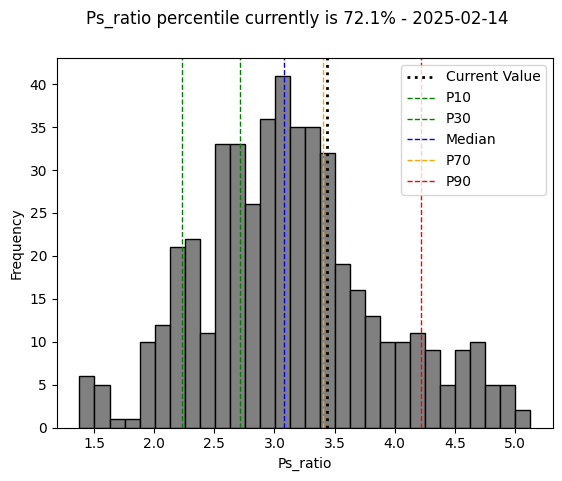

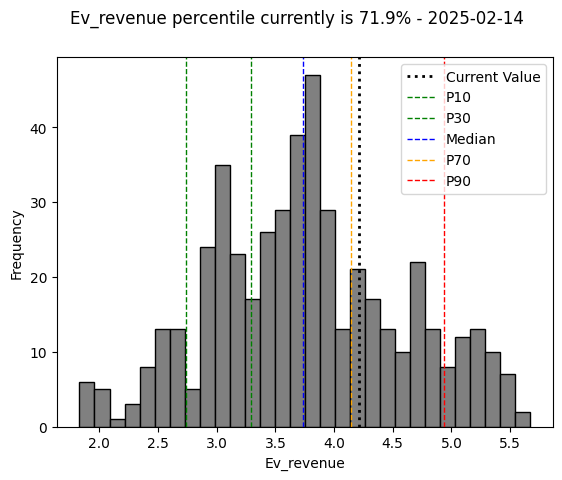

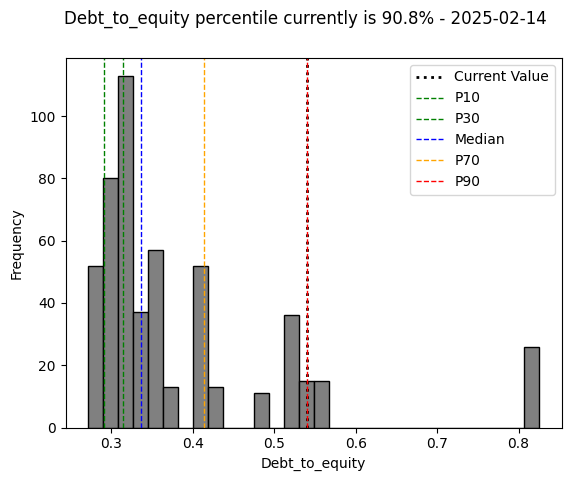

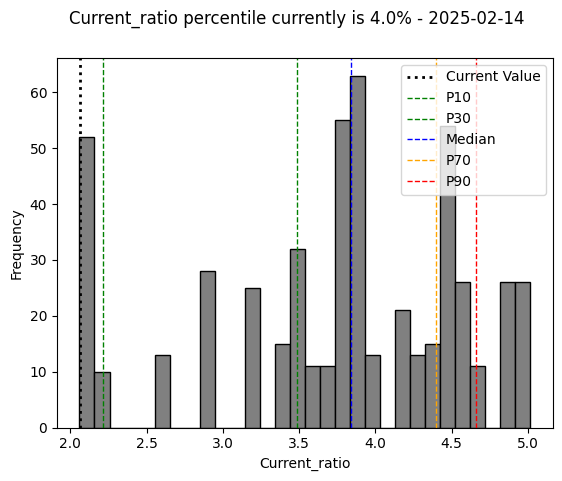

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.998806,0.008968,0.405866,0.381932,0.243501,-0.175529,0.251403
roe,0.998806,1.000000,0.012253,0.416950,0.388664,0.227843,-0.212573,0.270852
pe_ratio,0.008968,0.012253,1.000000,0.329914,0.251744,0.215646,0.023368,0.033311
pb_ratio,0.405866,0.416950,0.329914,1.000000,0.862776,0.502242,-0.270099,0.090632
ps_ratio,0.381932,0.388664,0.251744,0.862776,1.000000,0.820398,-0.172194,0.166742
ev_revenue,0.243501,0.227843,0.215646,0.502242,0.820398,1.000000,0.386662,-0.119433
debt_to_equity,-0.175529,-0.212573,0.023368,-0.270099,-0.172194,0.386662,1.000000,-0.660303
current_ratio,0.251403,0.270852,0.033311,0.090632,0.166742,-0.119433,-0.660303,1.000000


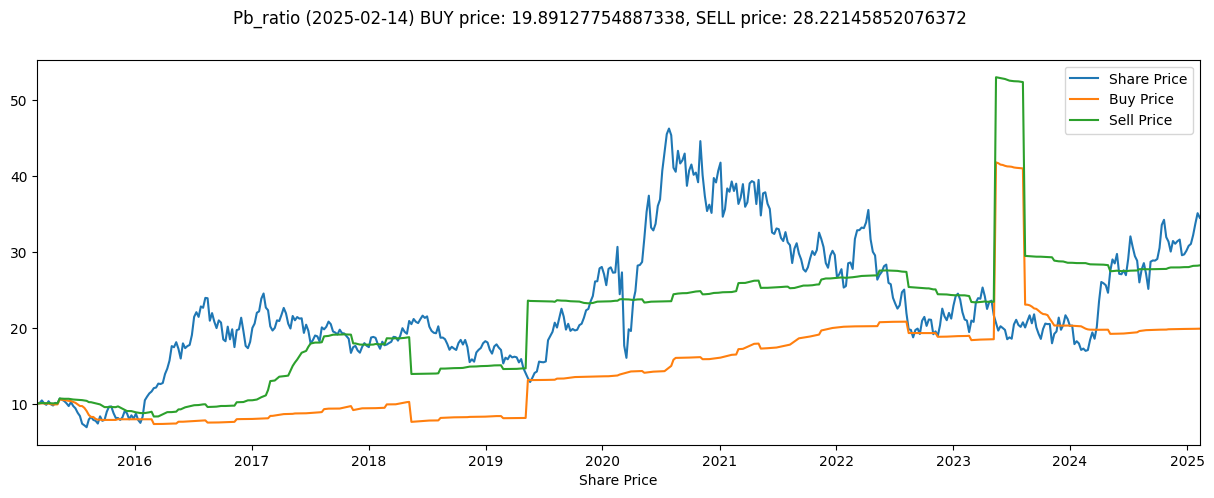

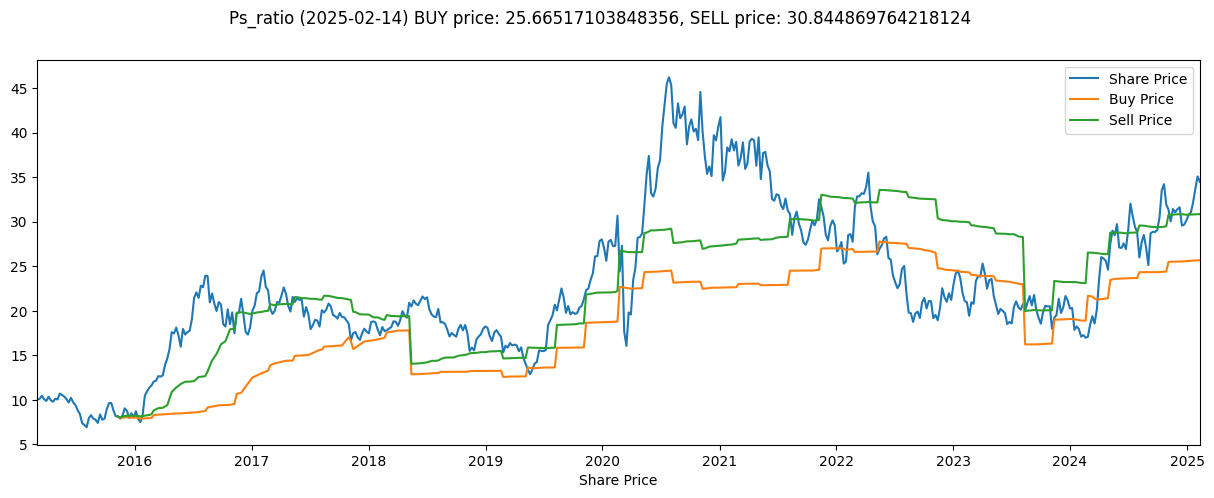

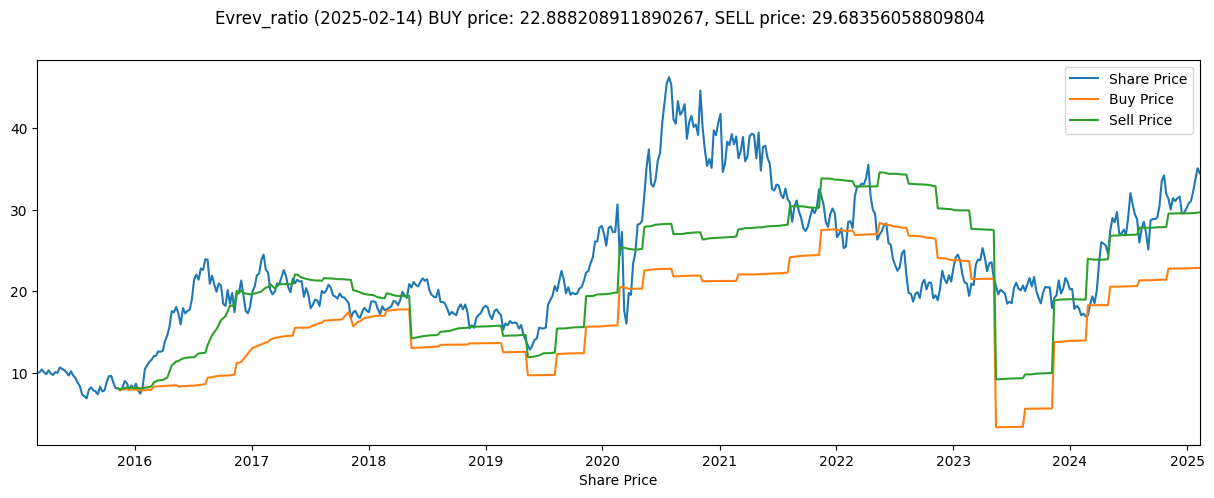

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)